# **Introduction to the STLAB light engine**
This notebook introduces the STLAB (SpectraTune Lab, Ledmotive) — a spectrally tuneable light engine with 10 LED colour channels, capable of generating a broad range of spectral compositions. The STLAB can be controlled programmatically with most languages using its **RESTFUL_API**, which takes commands via generic http requests. The API includes commands to set a specific spectrum, turn the light off, get readouts from the onboard spectrometer, etc. For this project I am developing a python module which uses the **requests** library to wrap around useful functions of the RESTFUL_API. It will also include other routines for working with the device. 

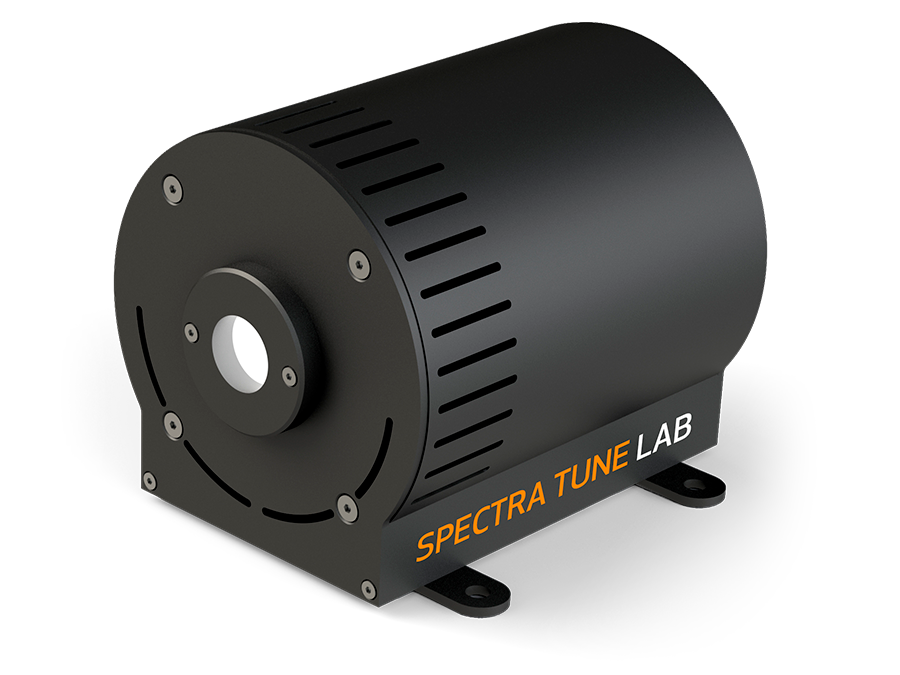

In [1]:
from time import sleep
import sys
import os
sys.path.insert(0, os.path.abspath('../../pyplr/'))

from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import stlab

sns.set_context("poster", font_scale=2)
sns.set_style("white")
%matplotlib inline

Image("/Users/jtm/Documents/cvd_pupillometry/img/STLAB.png", width=300)

Now, having imported the **stlab** module, and providing the device is properly connected, we can set it up as follows. The required password is device-specific. 

In [2]:
d = stlab.STLAB(username='admin', identity=1, password='83e47941d9e930f6')

STLAB device setup complete...


`stlab.STLAB(...)` returns an instance of the `STLAB()` class, which serves as a handle to control all available functionality. The class instance has an 'info' dict which contains some info that needs to be accessed by internal methods (i.e. 'url', 'id', and 'cookiejar'), and some other generic information about the configuration of the device. 

In [3]:
for k, v in d.info.items():
    print(k,'--->', v)

url ---> 192.168.7.2
id ---> 1
cookiejar ---> <RequestsCookieJar[<Cookie lighthub=s%3ADw4k4t6ihVHu0WbEKz8jd1U3_ISX494n.LLgGmlBaPYuZagHOHZy3RymGWAypg2xoBQ2Tzv2Ll3Y for 192.168.7.2/>]>
gateway ---> 0
csma_base_time ---> 60
default_spectrum ---> [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 100]
temperature_sensors_count ---> 4
power_limit ---> 100
pwm ---> [6, 2, 7, 7, 1, 9, 3, 6, 5, 8, 4, 0]
critical_temperature ---> 55
groups ---> [65535, 65535, 65535, 65535]
csma_random_time ---> 60
serial ---> MD02017000000400012
feedback_sensor ---> 1
model ---> VEGA10
warning_temperature ---> 50
power_protection ---> 100
channels ---> 10
address ---> 1


Let's play with some of the commands. In the following example, we set each LED in turn to its maximum intensity setting and take a reading from the on-board spectrometer. Note that the intensity of each LED is set with a value between 0 - 4095 (12-bit resolution depth), corresponding to the minimum and maximum input.

In [4]:
leds = [0,1,2,3,4,5,6,7,8,9]
intensity = [4095]
spectra , info = d.sample(leds=leds, intensities=intensity, wait_before_sample=0.2)

Sampling 10 leds at the following intensities: [4095]
Measurement: 1 / 10, LED: 0, intensity: 4095
Measurement: 2 / 10, LED: 1, intensity: 4095
Measurement: 3 / 10, LED: 2, intensity: 4095
Measurement: 4 / 10, LED: 3, intensity: 4095
Measurement: 5 / 10, LED: 4, intensity: 4095
Measurement: 6 / 10, LED: 5, intensity: 4095
Measurement: 7 / 10, LED: 6, intensity: 4095
Measurement: 8 / 10, LED: 7, intensity: 4095
Measurement: 9 / 10, LED: 8, intensity: 4095
Measurement: 10 / 10, LED: 9, intensity: 4095


In [6]:
spectra.index = pd.MultiIndex.from_frame(info[['led', 'intensity']])
spectra.reset_index(inplace=True)
long = spectra.melt(id_vars=['led','intensity'], var_name='wavelength', value_name='flux')
long.reset_index(inplace=True)
long = long.sort_values(by=['led','intensity'])

The `STLAB.sample(...)` method is just a convenient way of sampling a range of LEDs at some given intensity settings using the STLABs on-board spectrometer. It may also come in handy when we make measurements with an external spectrometer. 

In [25]:
%pinfo2 stlab.STLAB.sample

Signature:
stlab.STLAB.sample(
    self,
    leds=[0],
    intensities=[500],
    spectra=None,
    wait_before_sample=0.2,
    ocean_optics=None,
    randomise=False,
    save_output=False,
)
Docstring:
Sample a set of LEDs individually at a range of specified intensities 
using the STLABs on-board spectrometer. Or, alternatively, sample a set
of pre-defined spectra. Option to also obtain concurrent measurements 
with an external Ocean Optics spectrometer.

Parameters
----------
leds : list, optional
    List of unique integers from 0-9 representing the LEDs to sample.
    The default is [0].
intensities : list, optional
    List of integer values between 0-4095 representing the intensity 
    values at which to sample the LEDs. The default is [500].
spectra : list, optinal
    List of predfined spectra to sample. Must be None if specifying
    leds or intensities. The default is None.
wait_before_sample : float, optional
    Time in seconds to wait after setting a spectrum before acq

Now, using the data that we just collected, we can plot the spectral power distributions of the 10 channels at maximum and their CIE 1931 *xy* chromaticity coordinates, which define the gamut of the device. Note that the *xy* chromaticity coordinates can be quickly calculated by passing the output of `Device.sample_leds(...)` (or DataFrame with the same format) to `stlab.spectra_to_xyz(...)`

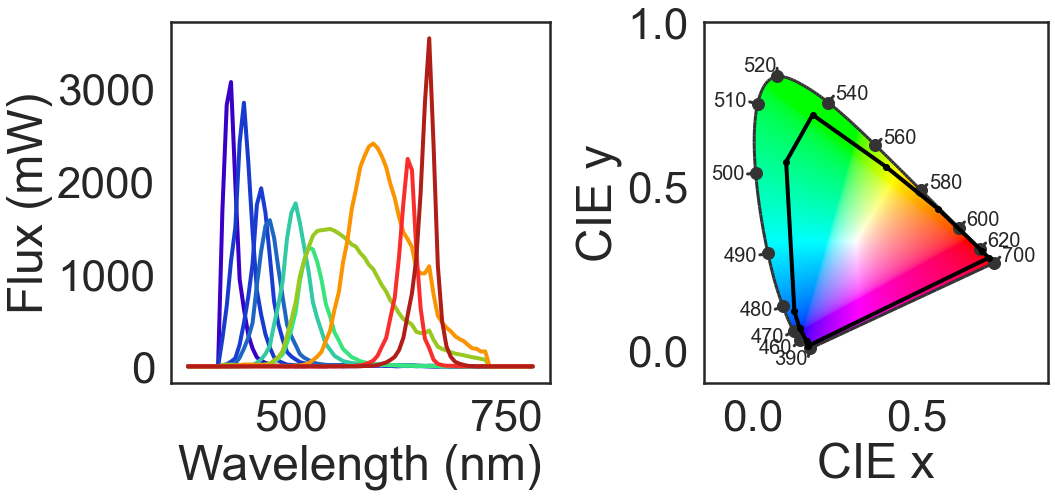

In [12]:
from colour.plotting import plot_chromaticity_diagram_CIE1931

# calculate xy chromaticity coordinates
xyz = stlab.spectra_to_xyz(long)
xyz = xyz.append(xyz.loc[0])

# set up figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

# plot SPDs
sns.lineplot(x='wavelength', y='flux', data=long, hue="led", palette=d.rgb_colors, ax=ax1, lw=4, legend=False)
ax1.set_xlabel("Wavelength (nm)")
ax1.set_ylabel("Flux (mW)")


# plotting the *CIE xy* chromaticity coordinates.
plot_chromaticity_diagram_CIE1931(standalone=False, axes=ax2, title=False, show_spectral_locus=True)
ax2.set_xlim((-.15,.9))
ax2.set_ylim((-.1,1))
ax2.plot(xyz["X"], xyz["Y"], color='k', lw=4, marker='o', markersize=6)
for item in ax2.texts:
    item.set_fontsize(20)
f.tight_layout()

f.savefig("/Users/jtm/Documents/cvd_pupillometry/data/stlab/spds_poster_gamut.svg")

For a more nuanced understanding of the device's output we would need to sample at a range of intensities, such as from minimum to maximum in steps of 63:

```Python
leds = [0,1,2,3,4,5,6,7,8,9]
intensities = [val for val in range(0,4096,65)]
spectra = d.sample_leds(leds=leds, intensity=intensities, wait_before_sample=.2)
```

But this will take about five minutes to run, so let's just load the results from csv.

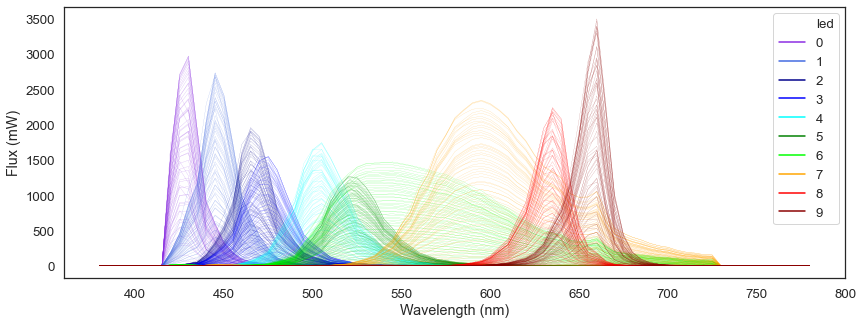

In [15]:
# load existing data
spectra = pd.read_csv("/Users/jtm/Documents/cvd_pupillometry/data/stlab/10led_65intensity.csv")

# set up figure
fig, ax = plt.subplots(figsize=(14,5))

# plot SPDs
sns.lineplot(x='wavelength', y='flux', data=spectra, hue='led', palette=colors, units='intensity', ax=ax, lw=.1, estimator=None)
ax.set_ylabel("Flux (mW)")
ax.set_xlabel("Wavelength (nm)")

fig.savefig("/Users/jtm/Documents/cvd_pupillometry/data/stlab/spds_10_leds_65_spec.png")

Looks like what we might reasonably expect, but it would be useful to see how the spectral power distributions for each LED vary in terms of *xy* chromaticity, as well as peak / dominant wavelength and melanopic irradiance as a function of input. I have created a convenient function for this. 

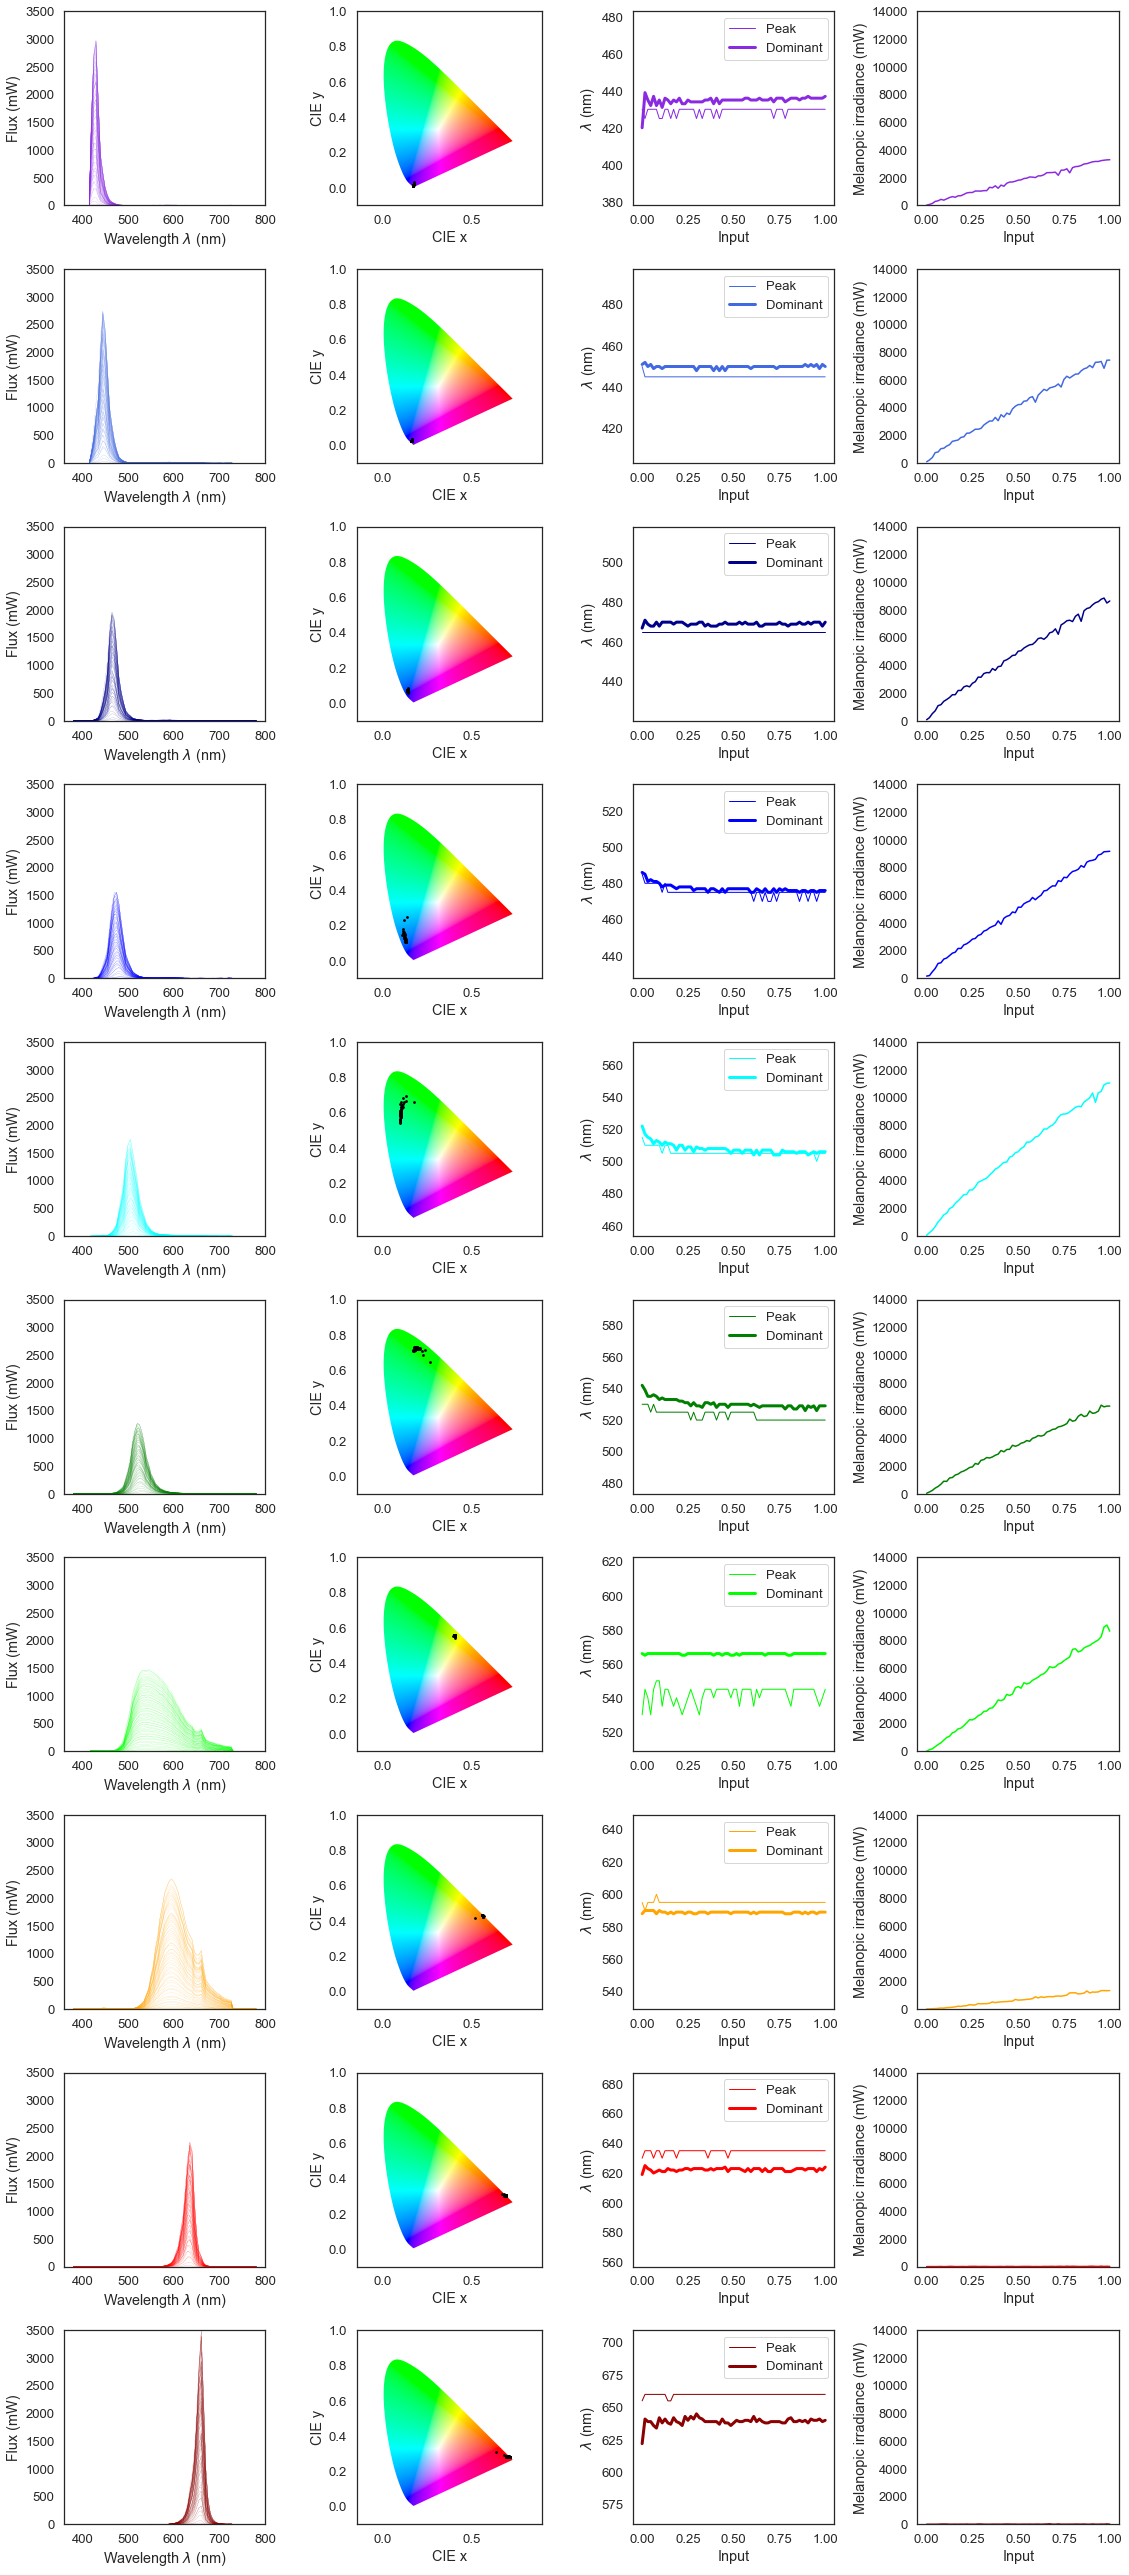

In [10]:
spectra = spectra.loc[spectra.intensity!=0]
fig = stlab.explore_spectra(spectra)

## **Forward model**
Using linear interpolation on these spectra we can create a lookup table to predict the spectral power distribution for each primary at all intensity levels between 0 and 4095. This can be thought of as a forward model of the device.

In [12]:
spectra = pd.read_csv("../../../data/stlab/10led_65intensity.csv", index_col=['led','intensity','wavelength'])
lkp_tbl = stlab.interp_spectra(spectra)
lkp_tbl.columns = wlbins
lkp_tbl

380.0  385.0  390.0  395.0  400.0  405.0  410.0  415.0  \
led intensity                                                           
0   0            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
    1            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
    2            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
    3            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
    4            0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...              ...    ...    ...    ...    ...    ...    ...    ...   
9   4091         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
    4092         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
    4093         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
    4094         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
    4095         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                  420.0     425.0  ...  735.0  740.0  745.0  750.0  755.0  \
led intensity                      ...                                      
0   0          0.000000  0.000000  ...    0.0    0.0    0.0    0.0    0.0   
    1          0.229296  0.398322  ...    0.0    0.0    0.0    0.0    0.0   
    2          0.458592  0.796645  ...    0.0    0.0    0.0    0.0    0.0   
    3          0.687888  1.194967  ...    0.0    0.0    0.0    0.0    0.0   
    4          0.917184  1.593289  ...    0.0    0.0    0.0    0.0    0.0   
...                 ...       ...  ...    ...    ...    ...    ...    ...   
9   4091       0.707791  0.049435  ...    0.0    0.0    0.0    0.0    0.0   
    4092       0.719787  0.037076  ...    0.0    0.0    0.0    0.0    0.0   
    4093       0.731783  0.024718  ...    0.0    0.0    0.0    0.0    0.0   
    4094       0.743780  0.012359  ...    0.0    0.0    0.0    0.0    0.0   
    4095       0.755776  0.000000  ...    0.0    0.0    0.0    0.0    0.0   

               760.0  765.0  770.0  775.0  780.0  
led intensity                                     
0   0            0.0    0.0    0.0    0.0    0.0  
    1            0.0    0.0    0.0    0.0    0.0  
    2            0.0    0.0    0.0    0.0    0.0  
    3            0.0    0.0    0.0    0.0    0.0  
    4            0.0    0.0    0.0    0.0    0.0  
...              ...    ...    ...    ...    ...  
9   4091         0.0    0.0    0.0    0.0    0.0  
    4092         0.0    0.0    0.0    0.0    0.0  
    4093         0.0    0.0    0.0    0.0    0.0  
    4094         0.0    0.0    0.0    0.0    0.0  
    4095         0.0    0.0    0.0    0.0    0.0  

[40960 rows x 81 columns]

Now we just need a function that, given some LED intensity settings and our lookup table, can predict the spectral output.

In [8]:
%pinfo2 stlab.predict_spd

Signature:
stlab.Device.predicted_spd(
    self,
    intensity=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    lkp_table=None,
)
Source:   
    def predicted_spd(self, intensity=[0,0,0,0,0,0,0,0,0,0], lkp_table=None):
        """
        Predict the spectral power distribution for a given list of led 
        intensities using linear interpolation.
    
        Parameters
        ----------
        intensity : list
            List of intensity values for each led. The default is [0,0,0,0,0,0,0,0,0,0].
        lkp_table : DataFrame
            A wide-format DataFrame with hierarchichal pd.MultIndex [led, intensity] 
            and a column for each of 81 5-nm wavelength bins. 4096*10 rows, containing
            predicted for each led at all possible intensities.
    
        Returns
        -------
        spectrum : np.array
            Predicted spectrum for given intensities.
        """
        spectrum = np.zeros(81)
        for led , val in enumerate(intensity):
            spectrum += lkp

If the STLAB is still connected, let's use our lookup table and `stlab.predicted_spd(...)` to predict the output for some random inputs and then compare this with a readout from the spectrometer. 

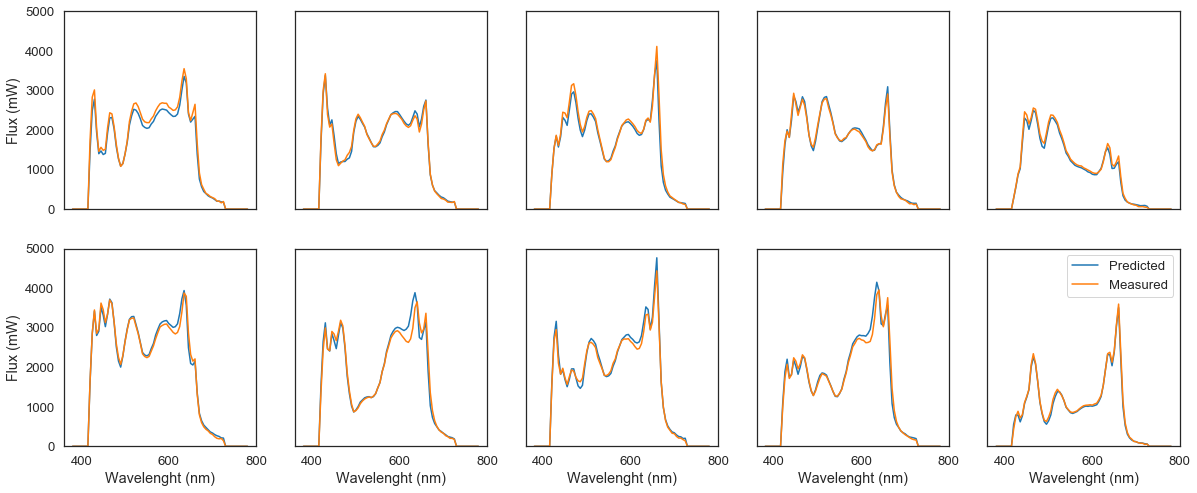

In [16]:
import random

# set up fgiure
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(20,8), sharey=True, sharex=True)
axs = [ax for sublist in axs for ax in sublist]

# predict, measure and plot for 8 random inputs
for ax in axs:
    random_input = [random.randrange(4096) for led in range(10)]
    predicted_spectrum = stlab.predict_spd(random_input, lkp_table=lkp_tbl)
    d.set_spectrum_a(random_input)
    measured_spectrum = d.get_spectrometer_spectrum(norm=False)
    d.turn_off()
    ax.plot(wlbins, predicted_spectrum, label="Predicted")
    ax.plot(wlbins, measured_spectrum, label='Measured')
    ax.set_ylim((0,5000))
    
for ax in [axs[0], axs[5]]:
    ax.set_ylabel("Flux (mW)")

for ax in axs[5:]:
    ax.set_xlabel("Wavelenght (nm)")

ax.legend()

Looks like the predictions are fairly accurate, but eventually it would be good to recreate this model with measurements taken from an external spectrometer looking into the integrating sphere. 

## **Device stability**
The manual for the STLAB claims perfect stability over time thanks to an on-board CMOS spectrophotometer and associated feedback loop control algorithms. But we can test this for ourselves:

```Python
leds = [0,1,2,3,4,5,6,7,8,9]
intensity = [4095]

df = pd.DataFrame()
for t in range(0,185,5):
    print("{} minutes left...".format(180-t))
    spectra = d.sample_leds(leds=leds, intensity=intensity, wait_before_sample=.5)
    spectra["time"] = t
    df = df.append(spectra)
    sleep(300)
df.to_csv("STLAB_stability.csv")
```
The above code samples each LED every (roughly) five minutes across 3 hours (36 measurements in total) and saves the results in a DataFrame. But to save time, let's just load some data generated by a previous run of this code. 

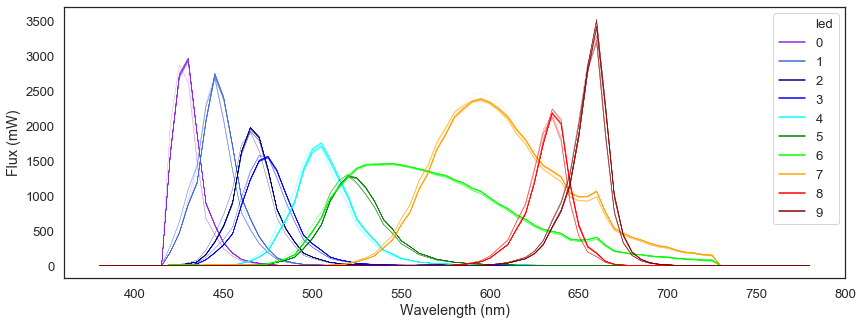

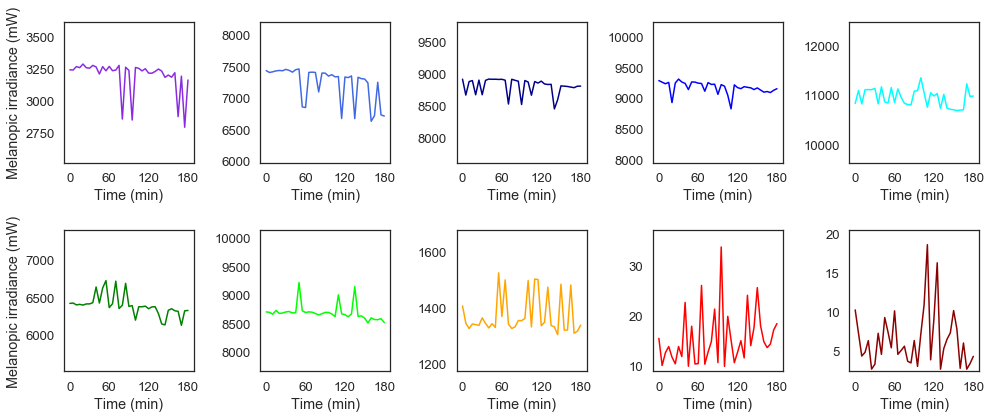

In [17]:
# load existing data
stability = pd.read_csv("../../../data/stlab/STLAB_3h_stability.csv")

# set up figure
fig, ax = plt.subplots(figsize=(14,5), sharex=True)

# plot SPDs
sns.lineplot(x='wavelength', y='flux', data=stability, hue='led', palette=colors, units='time', ax=ax, lw=.1, estimator=None)
ax.set_ylabel("Flux (mW)")
ax.set_xlabel("Wavelength (nm)")

# get max for led-cycle
maxs = stability.groupby(["led","time"])["flux"].max()

# plot
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(14,6))
axs = [ax for sublist in axs for ax in sublist]

for led, ax in enumerate(axs):
    mis = stlab.spectra_to_melanopic_irradiance(stability, grouper=['led','time'])
    mis.loc[led].plot(ax=ax, c=colors[led])
    low, high = mis.loc[led].min() - mis.loc[led].min() * 0.1, mis.loc[led].max() + mis.loc[led].max() * 0.1
    ax.set_ylim((low, high))
    #maxs.loc[led].plot(ax=ax, c=colors[led])
    #low, high = maxs.loc[led].min() - maxs.loc[led].min() * 0.1, maxs.loc[led].max() + maxs.loc[led].max() * 0.1
    #ax.set_ylim((low, high))
    
for ax in [axs[0], axs[5]]:
    ax.set_ylabel("Melanopic irradiance (mW)")
    
for ax in axs:
    ax.set_xlabel("Time (min)")
    ax.set_xticks((0,60,120,180))
    
fig.tight_layout()

## **Timing in synchronous mode**
The STLAB operates in ***synchronous*** mode by default, meaning that all commands sent by the LIGHT HUB must be acknowledged before a new instruction can be processed. The manual claims that response times in this mode of operation are on the order of around 250 milliseconds. We can test this. 

count    400.000000
mean       0.119784
std        0.007681
min        0.102159
25%        0.116358
50%        0.119533
75%        0.122504
max        0.150041
dtype: float64


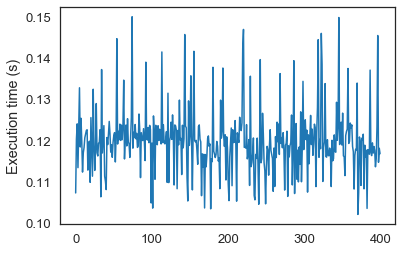

In [18]:
from time import time

spec = [4095]*10
off  = [0]*10
exec_times = []
for i in range(200):
    t1 = time()
    d.set_spectrum_a(spec)
    t2 = time()
    sleep(.2)
    t3 = time()
    d.set_spectrum_a(off)
    t4 = time()
    exec_times.append(t2-t1)
    exec_times.append(t4-t3)
    
exec_times = pd.Series(exec_times)
print(exec_times.describe())
ax = exec_times.plot()
ax.set_ylabel('Execution time (s)');

It probably depends on the machine, hardware, other processes, etc., but often we see worse timings, with commands sometimes taking up to 5 s to execute. Given that we may want to calculate (e.g.) accurate measures of pupil response times, the uncertainty here is problematic. Thankfully the STLAB also has an ***asynchronous*** mode of operation which allows for real-time spectral streaming with a spectral switching time of less than 10 milliseconds (i.e. 1 spectrum every 10 milliseconds). We will need to leverage this mode in order to get the desired control over the temporal properties of our light stimuli. 

## **Making video files to play in asynchronous mode**
For asynchronous mode we need to create video files, which are basically json files with a .dsf (dynamic sequence file) extension. Let's create a video file that sequentially ramps up each LED by 5 intensity steps every 10 ms. 

In [28]:
specs = []
t = 0
for led in range(10):
    for intensity in range(0, 4096, 5):
        spec = [0]*10
        spec[led] = intensity
        spec.insert(0, t)
        specs.append(spec)
        t += 10
specs = pd.DataFrame(specs)
cols = ["primary-" + str(val) for val in range(10)]
cols.insert(0, 'time')
specs.columns = cols
specs

,time,primary-0,primary-1,primary-2,primary-3,primary-4,primary-5,primary-6,primary-7,primary-8,primary-9
0,0,0,0,0,0,0,0,0,0,0,0
1,10,5,0,0,0,0,0,0,0,0,0
2,20,10,0,0,0,0,0,0,0,0,0
3,30,15,0,0,0,0,0,0,0,0,0
4,40,20,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
8195,81950,0,0,0,0,0,0,0,0,0,4075
8196,81960,0,0,0,0,0,0,0,0,0,4080
8197,81970,0,0,0,0,0,0,0,0,0,4085
8198,81980,0,0,0,0,0,0,0,0,0,4090


We can use `stlab.make_video_file(...)` to turn any DataFrame with the above format into a video file playable by the STLAB. The following requirements must currently be met:

1. The DataFrame has columns (in this order): time, primary-0, primary-1, primary-2, primary-3, primary-4, primary-5, primary-6, primary-7, primary-8, primary-9
2. The intensity settings range between 0 - 4095
3. Consecutive values of time differ by at least 10 ms (the file will still play, but spectra will be skipped)


In [29]:
stlab.make_video_file(specs, "our_video_file");

Now we can load and play the video file using `Device.load_video_file(...)` and `Device.play_video_file(...)`. If we want to stop playback of the video file prematurely, we can say `Device.play_video_file(stop=True)`

In [36]:
# load the video file
d.load_video_file(video="our_video_file.dsf")

# start playing the video file
d.play_video_file()

# wait for 20 s and stop playback
sleep(20.)
d.play_video_file(stop=True)
sleep(2)

# turn off the light
d.turn_off()